# Winddy

分析对抗训练时gradient masking现象

In [129]:
import torch
import os
import torchvision
import numpy as np
from LeNet import LeNet
import torchvision.transforms as transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [130]:
NORMALIZE = False
DEVICE = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [131]:
if NORMALIZE:
    trans = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
else:
    trans = transforms.Compose([
        transforms.ToTensor(),
    ])

In [132]:
data_home = '/data/winddy/'

train_set = torchvision.datasets.MNIST(root=os.path.join(data_home, 'dataset/MNIST'), train=True, download=True, transform=trans)
test_set = torchvision.datasets.MNIST(root=os.path.join(data_home, 'dataset/MNIST'), train=False, download=True, transform=trans)

In [133]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True, num_workers=2)

In [134]:
# 可视化数据集
def imshow(img):
    if NORMALIZE:
        img = img * 0.3081 + 0.1307
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()
    
class FGSM:
    def __init__(self, model, criterion, epsilon, device):
        self.model = model
        self.criterion = criterion
        self.epsilon = epsilon
        self.device = device
        assert isinstance(model, torch.nn.Module), "Input parameter model is not nn.Module. Check the model"
        assert isinstance(criterion, torch.nn.Module), "Input parameter criterion is no Loss. Check the criterion"
        assert (0 <= epsilon <= 1), "episilon must be 0 <= epsilon <= 1"
        self.model.eval()


    def __call__(self, input, labels):
        # For calculating gradient
        input_for_gradient = Variable(input, requires_grad=True).to(self.device)
        out = self.model(input_for_gradient)
        loss = self.criterion(out, Variable(labels))

        # Calculate gradient
        loss.backward()

        # Calculate sign of gradient
        signs = torch.sign(input_for_gradient.grad.data)

        # Add
        input_for_gradient.data = input_for_gradient.data + (self.epsilon * signs)

        return input_for_gradient, signs

## 正常模型

In [135]:
# 读取模型
if NORMALIZE:
    model_path = './model/LeNet_MNIST.pt'
else:
    model_path = './model/LeNet_MNIST_unNormalize.pt'

model = LeNet()
model.load_state_dict(torch.load(model_path))
model = model.to(DEVICE)

In [136]:
# 随便抽取一个样本

dataIterative = iter(test_loader)
images, target = dataIterative.next()

img = (images[0]).reshape([-1,1,28,28])

img_target = (target[0]).reshape([1,])
print(img_target.shape)

torch.Size([1])


In [137]:
model.eval()
# 求loss关于img的梯度
img_gradient = img.clone()
img_gradient = img_gradient.to(DEVICE)
img_gradient.requires_grad = True
img_target = img_target.to(DEVICE)

# ## 输出
output = model(img_gradient)
# ## 计算loss
loss_f = torch.nn.CrossEntropyLoss()
loss = loss_f(output, img_target)
# ## 求导
loss.backward()

print(img_gradient.is_leaf)
print(loss.detach().cpu().numpy())

True
0.012359619140625


In [138]:
g = torch.sign(img_gradient.grad.data)
g = g.reshape([28,28])

# 若
g_ = -g


In [139]:
def countLoss(e1, e2, g, g_, img, target, model):
    loss = torch.nn.CrossEntropyLoss()
    
    sizes = e1.shape[0]*e1.shape[1]
    img_tmp = np.tile(img.cpu(), (sizes,1,1,1))
    g_tmp = np.tile(g.cpu(), (sizes,1,1,1))
    g_tmp2 = np.tile(g_.cpu(), (sizes,1,1,1))
    target = np.tile(target.cpu(), sizes)
    
    e1 = e1.reshape([-1,1,1,1])
    e2 = e2.reshape([-1,1,1,1])
    
    img_adv = img_tmp + e1 * g_tmp + e2 * g_tmp2
    
    img_adv = torch.Tensor(img_adv)
    target = torch.Tensor(target).long()
    img_adv = img_adv.to(DEVICE)
    target = target.to(DEVICE)
    
    loss = torch.nn.CrossEntropyLoss()
    output = model(img_adv)
    loss_f = torch.nn.functional.cross_entropy(output, target, reduction='none')
    return loss_f

In [140]:
img_tmp = img.clone()
x = np.linspace(0, 16, 50)
y = np.linspace(0, 16, 50)
X, Y = np.meshgrid(x,y)
Z = countLoss(X,Y, g, g_, img, img_target, model)

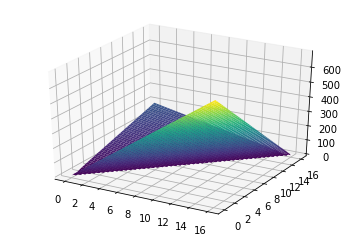

In [141]:
Z = Z.reshape([50,50])
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().cpu(), rstride=1, cstride=1, cmap='viridis', edgecolor='none')
plt.show()

## 对抗训练模型

In [153]:
# 读取模型

if NORMALIZE:
    model_path = './model/LeNet_MNIST_adv.pt'
else:
    model_path = './model/LeNet_MNIST_unNormalize_adv.pt'

model_adv = LeNet()
model_adv.load_state_dict(torch.load(model_path))
print('read model: {}'.format(model_path))
model_adv = model_adv.to(DEVICE)

read model: ./model/LeNet_MNIST_unNormalize_adv.pt


In [161]:
# 随便抽取一个样本

dataIterative = iter(test_loader)
images, target = dataIterative.next()

i = 10
img = (images[i]).reshape([-1,1,28,28])

img_target = (target[i]).reshape([1,])
print(img_target.shape)

torch.Size([1])


In [162]:
model.eval()
# 求loss关于img的梯度
img_gradient = img.clone()
img_gradient = img_gradient.to(DEVICE)
img_gradient.requires_grad = True
img_target = img_target.to(DEVICE)

# ## 输出
output = model_adv(img_gradient)
# ## 计算loss
loss_f = torch.nn.CrossEntropyLoss()
loss = loss_f(output, img_target)
# ## 求导
loss.backward()

print(img_gradient.is_leaf)
print(loss.detach().cpu().numpy())

True
0.0423736572265625


In [163]:
g = torch.sign(img_gradient.grad.data)
g = g.reshape([28,28])

# 若
g_ = torch.zeros_like(g)
for j in range(28):
    for i in range(14):
        a = g[j, i*2]
        b = g[j, i*2 +1]
        if a == 1 and b == 1:
            g_[j, i*2] = 1
            g_[j, i*2+1] = -1
        if a == 1 and b == -1:
            g_[j, i*2] = -g[j, i*2]
            g_[j, i*2+1] = -g[j, i*2 + 1]
        if a == -1 and b== -1:
            g_[j, i*2] = -1
            g_[j, i*2+1] = 1
        if a == -1 and b == 1:
            g_[j, i*2] = -g[j, i*2]
            g_[j, i*2+1] = -g[j, i*2 + 1]

In [166]:
img_tmp = img.clone()
x = np.linspace(0, 14, 50)
y = np.linspace(0, 14, 50)
X, Y = np.meshgrid(x,y)
Z = countLoss(X,Y, g, g_, img, img_target, model_adv)

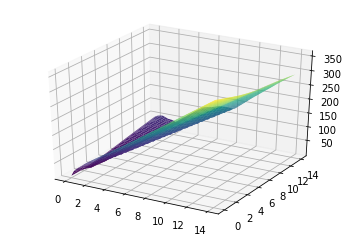

In [167]:
Z = Z.reshape([50,50])
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().cpu(), rstride=1, cstride=1, cmap='viridis', edgecolor='none')
plt.show()